<a href="https://colab.research.google.com/github/nileshmalode11/NER_with_tensorflow_bert/blob/main/NER_tensorflow_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NER USING BERT**

## The goal of a named entity recognition (NER) system is to identify all textual mentions of the named entities. This can be broken down into two sub-tasks: identifying the boundaries of the NE, and identifying its type.

Named entity recognition is a task that is well-suited to the type of classifier-based approach. In particular, a tagger can be built that labels each word in a sentence using the IOB format, where chunks are labelled by their appropriate type.

The IOB Tagging system contains tags of the form:

B - {CHUNK_TYPE} – for the word in the Beginning chunk
I - {CHUNK_TYPE} – for words Inside the chunk
O – Outside any chunk
The IOB tags are further classified into the following classes –

geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time indicator
art = Artifact
eve = Event
nat = Natural Phenomenon

## **1. Connecting To TPU**

In [ ]:
import tensorflow  as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## **2. Importing Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## **3. Loading Dataset**

In [ ]:
dataframe = pd.read_csv("/kaggle/input/entity-annotated-corpus/ner_dataset.csv",encoding = 'ISO-8859-1',error_bad_lines = False)
dataframe = dataframe.dropna()
dataframe.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
24,Sentence: 2,Families,NNS,O
54,Sentence: 3,They,PRP,O
68,Sentence: 4,Police,NNS,O
83,Sentence: 5,The,DT,O


In [ ]:
dataframe.Tag.unique()
print(f"Number of Tags : {len(dataframe.Tag.unique())}")

Number of Tags : 9


## **4. Exploratory Data Analysis**

In [ ]:
pie = dataframe['Tag'].value_counts()
px.pie(names = pie.index,values= pie.values,hole = 0.5,title ='Total Count of Tags')

In [ ]:
bar = dataframe['POS'].value_counts()
px.bar(x = bar.index,y = bar.values,title = "Total Count of Parts of Speech",color = bar.index)

## **5. Grouping, Tokenizing and Padding**

In [ ]:
dataframe["Sentence #"] = dataframe["Sentence #"].fillna(method="ffill")
sentence = dataframe.groupby("Sentence #")["Word"].apply(list).values
pos = dataframe.groupby(by = 'Sentence #')['POS'].apply(list).values
tag = dataframe.groupby(by = 'Sentence #')['Tag'].apply(list).values

In [ ]:
def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag

sentence,pos,tag,enc_pos,enc_tag = process_data("/kaggle/input/entity-annotated-corpus/ner_dataset.csv")

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = 128
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')


        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

## **6. Train test split on Sentance And Tag**

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=42,test_size=0.1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((43163,), (4796,), (43163,), (4796,))

In [ ]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)

100%|██████████| 43163/43163 [00:14<00:00, 2979.61it/s]


In [ ]:
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 4796/4796 [00:01<00:00, 3300.13it/s]


## **7. Testing Padding and Truncation Length**

In [ ]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{128}

In [ ]:
# Train Padding
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (128-len(y_test[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{128}

In [ ]:
# Train Padding
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (128-len(y_train[i]))))

# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{128}

## **8. Building BERT Model : Transfer Learning**

In [ ]:
# bert_model = TFBertModel.from_pretrained('bert-base-uncased')

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(17,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [ ]:
# with strategy.scope():
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
model = create_model(bert_model,MAX_LEN)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 128, 768)     0           tf_bert_model[0][0]          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


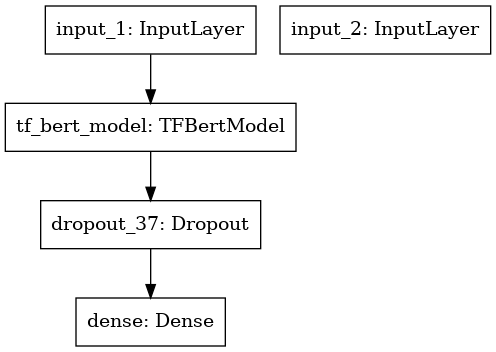

In [ ]:
tf.keras.utils.plot_model(model)

## **9. Traning Model**

In [ ]:
early_stopping = EarlyStopping(mode='min',patience=5)
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 1,batch_size = 30*2,callbacks = early_stopping,verbose = True)

720/720 [==============================] - 1112s 2s/step - loss: 0.1578 - accuracy: 0.9572 - val_loss: 0.0686 - val_accuracy: 0.9789


In [ ]:
model.save_weights("ner_bert_weights")

## **10. visulization of model performance on train and validation data**

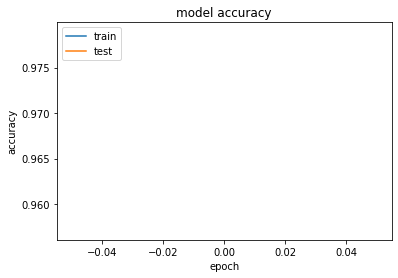

In [ ]:
plt.plot(history_bert.history['accuracy'])
plt.plot(history_bert.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

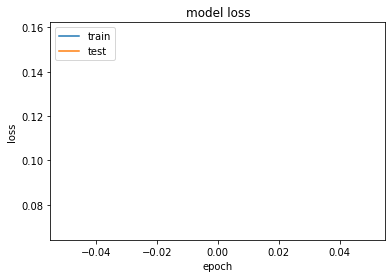

In [ ]:
plt.plot(history_bert.history['loss'])
plt.plot(history_bert.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **11. Testing Model**

In [ ]:
def pred(val_input_ids,val_attention_mask):
    return model.predict([val_input_ids,val_attention_mask])

In [ ]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,128)
    val_attention = val_attention_mask.reshape(1,128)

    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    print("Original Text : ",str(sentence))
    print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    print("Original Tags : " ,str(true_enc_tag))
    print("\n")

    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1)
    pred_without_pad = pred_with_pad[pred_with_pad>0]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    print("Predicted Tags : ",pred_enc_tag)


In [ ]:
testing(val_input_ids[0],val_attention_mask[0],enc_tag,y_test[0])

Original Text :  [CLS] the report calls on president bush and congress to urge chinese officials not to use the global war against terrorism as a pretext to suppress minorities'rights. [SEP]


Original Tags :  ['O' 'O' 'O' 'O' 'B-per' 'I-per' 'O' 'B-org' 'O' 'O' 'B-gpe' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


Predicted Tags :  ['O' 'O' 'O' 'O' 'B-per' 'I-per' 'O' 'O' 'O' 'O' 'B-gpe' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


**Looking at Original Tags and Predicted Tags, Both seems Equal. Which Means, Model Has Performed well.**